In [1]:
from src.preprocessing.preprocess_ucr import UCRDatasetImporter
from src.preprocessing.data_pipeline import build_data_pipeline
from src.utils import load_yaml_param_settings
from src.models.vqvae_classification import BaseVQVAE
from sklearn import metrics

import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib widget

do: pip3 install ipympl to view the 3d plots interactively

Define which dataset to analyse here:

In [14]:
dataset_analysis = 'ScreenType'

Loading vqvae and data

In [15]:
config_dir = 'src/configs/config.yaml' #dir to config file

config = load_yaml_param_settings(config_dir)

config['dataset']['dataset_name'] = dataset_analysis

# data pipeline
dataset_importer = UCRDatasetImporter(**config['dataset'])
batch_size = config['dataset']['batch_sizes']['vqvae']
train_data_loader, test_data_loader = [build_data_pipeline(batch_size, dataset_importer, config, kind) for kind in ['train', 'test']]

input_length = train_data_loader.dataset.X.shape[-1]

vqvae = BaseVQVAE(input_length, config)

self.X_train.shape: (375, 720)
self.X_test.shape: (375, 720)
# unique labels (train): [0 1 2]
# unique labels (test): [0 1 2]


grabbing zqs

In [16]:
zqs_train = vqvae.run_through_codebook(train_data_loader)
y_train = train_data_loader.dataset.Y.flatten().astype(int)

zqs_test = vqvae.run_through_codebook(test_data_loader)
y_test = test_data_loader.dataset.Y.flatten().astype(int)


## T-SNE

In [17]:
from sklearn.manifold import TSNE

zqs_test_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs_test)
zqs_train_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs_train)
zqs_test_embedded3 = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs_test)
zqs_train_embedded3 = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs_test)

In [18]:
print("zqs_train_embedding shape:", zqs_train_embedded2.shape)
print("zqs_train shape:", zqs_train.shape)
print("zqs_test_embedding shape:", zqs_test_embedded2.shape)
print("zqs_test shape:", zqs_test.shape)

zqs_train_embedding shape: (375, 2)
zqs_train shape: (375, 3520)
zqs_test_embedding shape: (375, 2)
zqs_test shape: (375, 3520)


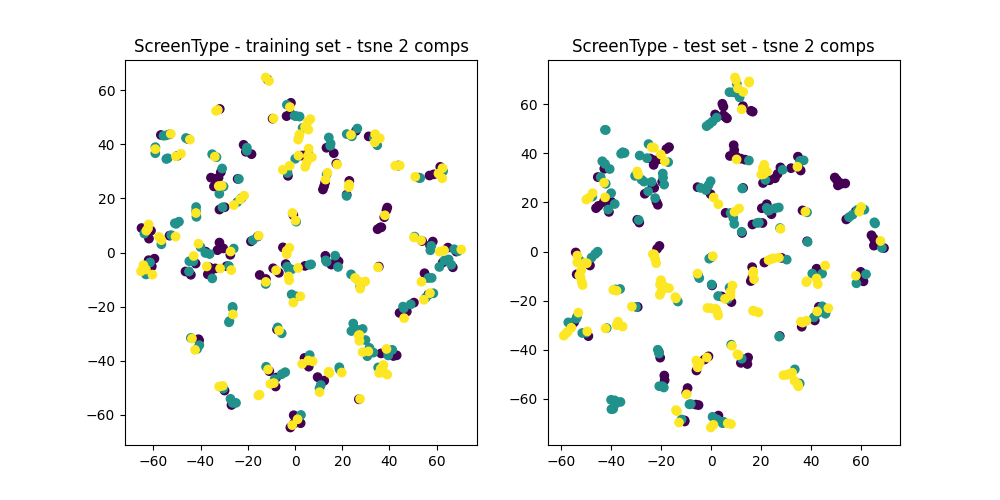

In [19]:
f, ax = plt.subplots(1, 2)
f.set_figheight(5); f.set_figwidth(10)
ax[0].scatter(zqs_train_embedded2[:, 0], zqs_train_embedded2[:, 1], c=y_train)
ax[1].scatter(zqs_test_embedded2[:, 0], zqs_test_embedded2[:, 1], c=y_test)
ax[0].set_title(f"{config['dataset']['dataset_name']} - training set - tsne 2 comps")
ax[1].set_title(f"{config['dataset']['dataset_name']} - test set - tsne 2 comps")
plt.show()

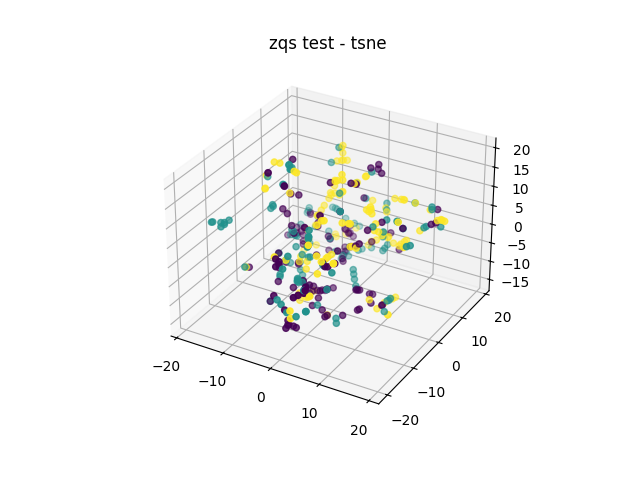

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zqs_train_embedded3[:, 0], zqs_train_embedded3[:, 1], zqs_train_embedded3[:, 2], c=y_test)
ax.set_title("zqs test - tsne")
plt.show()

## PCA on discrete latent variables zq's


In [21]:
from sklearn.decomposition import PCA

pca2_test = PCA(n_components=2).fit(zqs_test)
pca3_test = PCA(n_components=3).fit(zqs_test)

pca2_train = PCA(n_components=2).fit(zqs_train)
pca3_train = PCA(n_components=3).fit(zqs_train)

print("sum variance explained test 2 comps:", sum(pca2_test.explained_variance_ratio_))
print("sum variance explained test 3 comps:", sum(pca3_test.explained_variance_ratio_))
print("sum variance explained train 2 comps:", sum(pca2_train.explained_variance_ratio_))
print("sum variance explained train 3 comps:", sum(pca3_train.explained_variance_ratio_))

sum variance explained test 2 comps: 0.28256769478321075
sum variance explained test 3 comps: 0.360485315322876
sum variance explained train 2 comps: 0.2612690180540085
sum variance explained train 3 comps: 0.3215581402182579


In [22]:
zqs_test_2pc = pca2_test.fit_transform(zqs_test)
zqs_test_3pc = pca3_test.fit_transform(zqs_test)
zqs_train_2pc = pca2_train.fit_transform(zqs_train)
zqs_train_3pc = pca3_train.fit_transform(zqs_train)

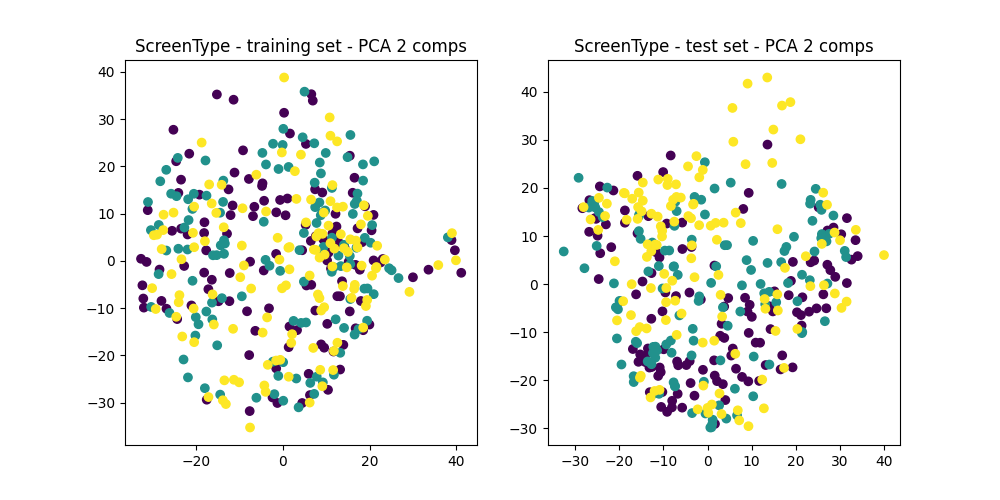

In [23]:
f, ax = plt.subplots(1, 2)
f.set_figheight(5); f.set_figwidth(10)
ax[0].scatter(zqs_train_2pc[:, 0], zqs_train_2pc[:, 1], c=y_train)
ax[1].scatter(zqs_test_2pc[:, 0], zqs_test_2pc[:, 1], c=y_test)
ax[0].set_title(f"{config['dataset']['dataset_name']} - training set - PCA 2 comps")
ax[1].set_title(f"{config['dataset']['dataset_name']} - test set - PCA 2 comps")
plt.show()

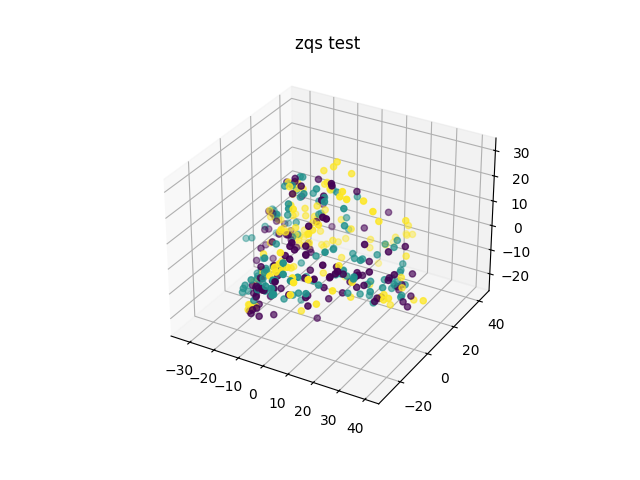

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zqs_test_3pc[:, 0], zqs_test_3pc[:, 1], zqs_test_3pc[:, 2], c=y_test)
ax.set_title("zqs test")
plt.show()

Text(0.5, 0.92, 'zqs train')

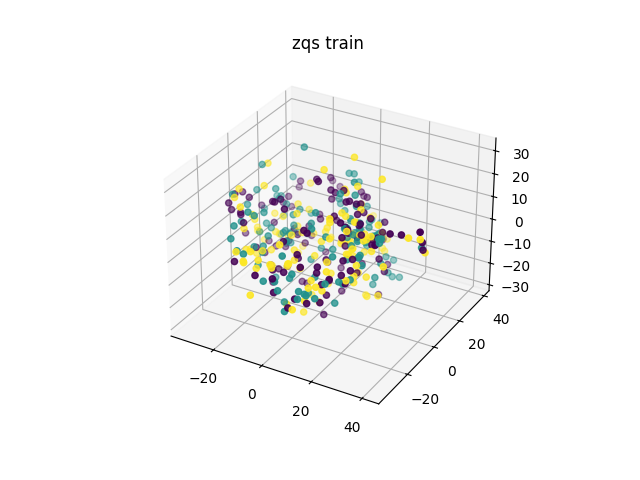

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zqs_train_3pc[:, 0], zqs_train_3pc[:, 1], zqs_train_3pc[:, 2], c=y_train)
ax.set_title("zqs train")

## Codebook analysis

In [27]:
codebook = vqvae.get_codebook()

pca_codebook_3 = PCA(n_components=3)
pca_codebook_3.fit(codebook)

pca_codebook_2 = PCA(n_components=2)
pca_codebook_2.fit(codebook)

PCA(n_components=2)

3 comps:

In [28]:
print(pca_codebook_3.explained_variance_ratio_)
print(sum(pca_codebook_3.explained_variance_ratio_))

[0.494315   0.2819094  0.16001962]
0.9362440296333253


2 comps:

In [29]:
print(pca_codebook_2.explained_variance_ratio_)
print(sum(pca_codebook_2.explained_variance_ratio_))

[0.494315  0.2819094]
0.7762244047379723


In [30]:
print(pca_codebook_2.explained_variance_ratio_)
print(sum(pca_codebook_3.explained_variance_ratio_))

[0.494315  0.2819094]
0.9362440296333253


In [31]:
codebook_pca3_transformed = pca_codebook_3.fit_transform(codebook)
codebook_pca2_transformed = pca_codebook_2.fit_transform(codebook)

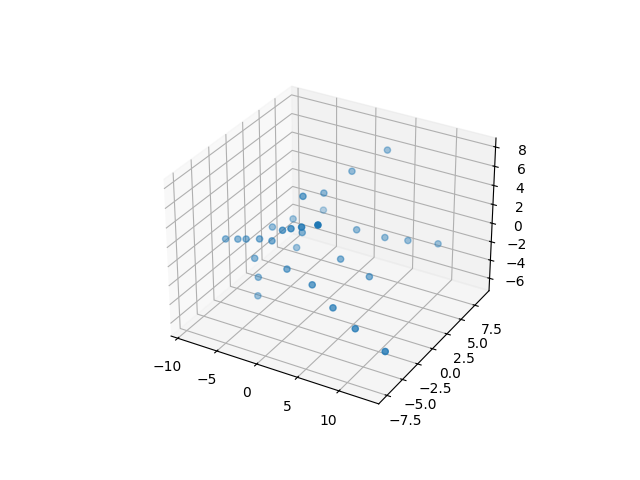

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(codebook_pca3_transformed[:, 0], codebook_pca3_transformed[:, 1], codebook_pca3_transformed[:, 2])
plt.show()

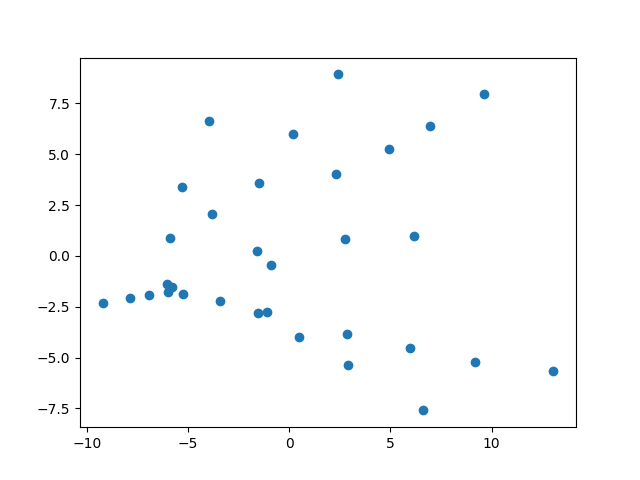

In [33]:
f, ax = plt.subplots()
ax.scatter(codebook_pca2_transformed[:, 0], codebook_pca2_transformed[:, 1])
plt.show()